### import libraries

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
from sklearn.cluster import KMeans
import random
from scipy.stats import skewnorm
import plotly.graph_objects as go
pd.set_option("max.columns", 30)
pd.set_option('display.max_columns', None)

import plotly.io as pio
pio.renderers
pio.renderers.default = 'svg'

### import zip code csv (AL, GA, MS, SC)

In [2]:
AL_ZIP_CODES = pd.read_csv('https://raw.githubusercontent.com/PhilipHarvey20/Network-Optimization---K-Means/master/AL_ZIPCODES.csv')
GA_ZIP_CODES = pd.read_csv('https://raw.githubusercontent.com/PhilipHarvey20/Network-Optimization---K-Means/master/GA_ZIPCODES.csv')
MS_ZIP_CODES = pd.read_csv('https://raw.githubusercontent.com/PhilipHarvey20/Network-Optimization---K-Means/master/MS_ZIPCODES.csv')
SC_ZIP_CODES = pd.read_csv('https://raw.githubusercontent.com/PhilipHarvey20/Network-Optimization---K-Means/master/SC_ZIPCODES.csv')
us_coordinate_lookup = pd.read_csv('https://raw.githubusercontent.com/PhilipHarvey20/Network-Optimization---K-Means/master/USZIPCodes202204.csv')

2018 Actual Hunting License Sales by State

- AL - 548k
- GA - 652k
- MS - 300k
- SC - 181k

# Hyperparameters

In [3]:
no_of_clusters = 9

### Generate random # of license sales per zip in AL, GA, MS, SC

In [4]:
# Generate random count of hunt. license per zip code in AL (total 548k)
AL_ZIP_CODES['num_of_licenses'] = np.around(np.random.dirichlet
                        (np.ones(AL_ZIP_CODES.shape[0]),size=10)[0],
                         decimals = 15)
AL_ZIP_CODES['num_of_licenses'] = AL_ZIP_CODES['num_of_licenses'] * 548000

# Generate random count of hunt. license per zip code in GA (total 652k)
GA_ZIP_CODES['num_of_licenses'] = np.around(np.random.dirichlet
                        (np.ones(GA_ZIP_CODES.shape[0]),size=10)[0],
                         decimals = 15)
GA_ZIP_CODES['num_of_licenses'] = GA_ZIP_CODES['num_of_licenses'] * 652000

# Generate random count of hunt. license per zip code in MS (total 300k)
MS_ZIP_CODES['num_of_licenses'] = np.around(np.random.dirichlet
                        (np.ones(MS_ZIP_CODES.shape[0]),size=10)[0],
                         decimals = 15)
MS_ZIP_CODES['num_of_licenses'] = MS_ZIP_CODES['num_of_licenses'] * 300000

# Generate random count of hunt. license per zip code in SC (total 181k)
SC_ZIP_CODES['num_of_licenses'] = np.around(np.random.dirichlet
                        (np.ones(SC_ZIP_CODES.shape[0]),size=10)[0],
                         decimals = 15)
SC_ZIP_CODES['num_of_licenses'] = SC_ZIP_CODES['num_of_licenses'] * 181000

### Concat AL, MS, GA, and SC datasets into one

In [5]:
df=pd.concat([AL_ZIP_CODES,GA_ZIP_CODES,MS_ZIP_CODES,SC_ZIP_CODES],ignore_index=True)
df.shape

(2727, 6)

In [6]:
# format zip field as str
df['zip'] = df['zip'].astype(str)
df['zip'] = df['zip'].str.strip()
us_coordinate_lookup['Zip Code'] = us_coordinate_lookup['Zip Code'].astype(str)
us_coordinate_lookup['Zip Code'] = us_coordinate_lookup['Zip Code'].str.strip()
# dropping columns from us_coordinate_lookup we don't need
us_coordinate_lookup = us_coordinate_lookup[['Zip Code','ZipLatitude','ZipLongitude']]
# drop duplicate zip codes in us_coordinate_lookup
us_coordinate_lookup = us_coordinate_lookup.drop_duplicates(subset=['Zip Code'], keep='first')

In [7]:
#check df before join
df.shape

(2727, 6)

In [8]:
#rename zip code column from us_coordinate_lookup
us_coordinate_lookup.rename(columns = {'Zip Code':'zip','ZipLatitude':'lat','ZipLongitude':'lon'},inplace = True)
# add columns for lat/lon onto df
cols = ['zip']
df = df.join(us_coordinate_lookup.set_index(cols), on=cols)

In [9]:
# check df size after join
df.shape

(2727, 8)

In [10]:
# drop null lat/lon rows from df
df = df[df['lon'].isnull()==False]
df = df[df['lat'].isnull()==False]
# check for null lat/lon values
df[df['lat'].isnull()].shape

(0, 8)

In [11]:
df.head(3)

,zip,Zipcode name,City,State,County Name,num_of_licenses,lat,lon
0,36310,"ABBEVILLE, AL",ABBEVILLE,AL,HENRY,288.895015,31.593513,-85.228148
1,35005,"ADAMSVILLE, AL",ADAMSVILLE,AL,JEFFERSON,725.685925,33.592857,-86.994015
2,35540,"ADDISON, AL",ADDISON,AL,WINSTON,290.682614,34.202745,-87.204788


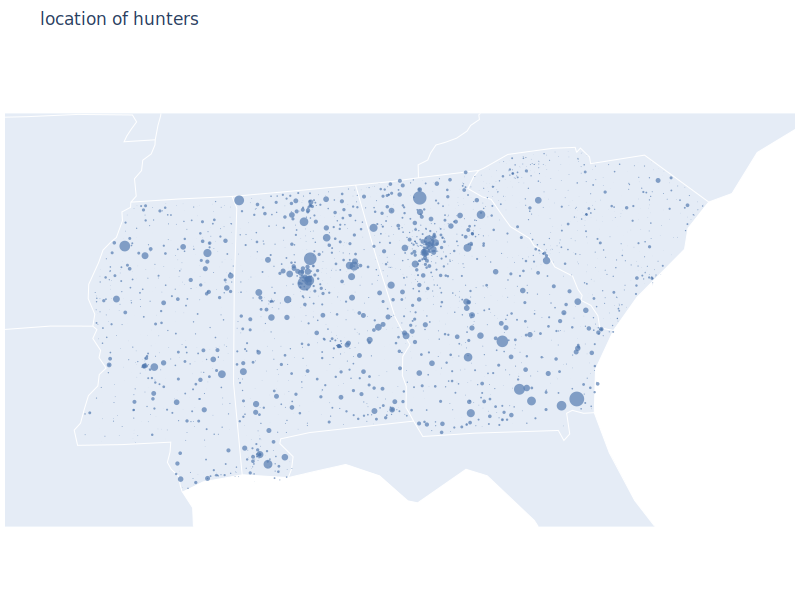

In [12]:
fig = go.Figure()
fig.add_trace(go.Scattergeo(
    locationmode = 'USA-states',
    lon = df['lon'],
    lat = df['lat'],
    hoverinfo = 'text',
    text = df['County Name'] + ' County',
    mode = 'markers',
    marker = dict(
        size = df['num_of_licenses']/420,
        color = 'rgb(86, 125, 177)',
        line = dict(
            width = 3,
            color = 'rgba(68, 68, 68, 0)'
        )
    )))

fig.update_layout(
    geo_scope='usa',
    width=800,
    height=600,
    margin=dict(
        l=5,
        r=5,
        b=10,
        t=50,
        pad=4
    ),
    title_text ='location of hunters',
    showlegend = False,
    )
fig.update_geos(fitbounds="locations")
fig.show()

# K - MEANS WEIGHTED *** START HERE

In [13]:
df.head(5)

,zip,Zipcode name,City,State,County Name,num_of_licenses,lat,lon
0,36310,"ABBEVILLE, AL",ABBEVILLE,AL,HENRY,288.895015,31.593513,-85.228148
1,35005,"ADAMSVILLE, AL",ADAMSVILLE,AL,JEFFERSON,725.685925,33.592857,-86.994015
2,35540,"ADDISON, AL",ADDISON,AL,WINSTON,290.682614,34.202745,-87.204788
3,35006,"ADGER, AL",ADGER,AL,JEFFERSON,310.530210,33.446190,-87.222997
4,35441,"AKRON, AL",AKRON,AL,HALE,519.520068,32.855328,-87.715739


### Define X, Y and set no of iterations

In [14]:
df.columns

Index(['zip', 'Zipcode name', 'City', 'State', 'County Name',
       'num_of_licenses', 'lat', 'lon'],
      dtype='object')

In [15]:
no_of_clusters

9

In [16]:
kmeans = KMeans(n_clusters=(no_of_clusters), random_state=0, max_iter=1000)
X = np.array(df.drop(['zip', 'Zipcode name', 'City', 'State', 'County Name','num_of_licenses'], 1).astype(float))
Y = np.array(df['num_of_licenses'].astype(float))

/var/folders/kj/vr71j0vx6873_skkn0nf_sxm0000gn/T/ipykernel_92952/3186758828.py:2: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



### Step 4: Run the weighted k-means clustering and enter the ‘X’ array as the input and ‘Y’ array as sample weights. Generate the cluster levels for all data points

In [17]:
wt_kmeansclus = kmeans.fit(X,sample_weight = Y)
predicted_kmeans = kmeans.predict(X, sample_weight = Y)

### Step 5: Visualize the clusters and the centroids in a scatter plot



In [18]:
centers = wt_kmeansclus.cluster_centers_

## Join clusters lat/lon and label back onto dataframe

In [19]:
df['CLUSTER_NAME'] = predicted_kmeans
centersdf=pd.DataFrame(centers)
centersdf['CLUSTER_NAME'] = centersdf.index
centersdf=centersdf.rename(columns = {0:'CLUSTER_LAT',1:'CLUSTER_LON'})
df=df.merge(centersdf,on='CLUSTER_NAME',how='left')
df.head()

,zip,Zipcode name,City,State,County Name,num_of_licenses,lat,lon,CLUSTER_NAME,CLUSTER_LAT,CLUSTER_LON
0,36310,"ABBEVILLE, AL",ABBEVILLE,AL,HENRY,288.895015,31.593513,-85.228148,3,31.993804,-85.533937
1,35005,"ADAMSVILLE, AL",ADAMSVILLE,AL,JEFFERSON,725.685925,33.592857,-86.994015,7,33.870278,-86.726846
2,35540,"ADDISON, AL",ADDISON,AL,WINSTON,290.682614,34.202745,-87.204788,7,33.870278,-86.726846
3,35006,"ADGER, AL",ADGER,AL,JEFFERSON,310.530210,33.446190,-87.222997,7,33.870278,-86.726846
4,35441,"AKRON, AL",AKRON,AL,HALE,519.520068,32.855328,-87.715739,7,33.870278,-86.726846


## Plot Results

In [20]:
fig = go.Figure()

paths = []
for i in range(len(df)):
    fig.add_trace(
        go.Scattergeo(
            locationmode = 'USA-states',
            lon = [df['CLUSTER_LON'][i], df['lon'][i]],
            lat = [df['CLUSTER_LAT'][i], df['lat'][i]],
            mode = 'lines',
            line = dict(width = 1,color = 'green'),
            opacity = float(df['num_of_licenses'][i]) / float(df['num_of_licenses'].max()),
        )
    )

fig.add_trace(go.Scattergeo(
    locationmode = 'USA-states',
    lon = df['lon'],
    lat = df['lat'],
    hoverinfo = 'text',
    text = df['num_of_licenses'],
    mode = 'markers',
    marker = dict(
        size = df['num_of_licenses']/450,
        color = 'rgb(86, 125, 177)',
        line = dict(
            width = 3,
            color = 'rgba(68, 68, 68, 0)'
        )
    )))

fig.add_trace(go.Scattergeo(
    locationmode = 'USA-states',
    lon = df['CLUSTER_LON'],
    lat = df['CLUSTER_LAT'],
    hoverinfo = 'text',
    text = df['CLUSTER_NAME'],
    mode = 'markers',
    marker_symbol='x',
    marker = dict(
        size = 12,
        color = 'rgb(229, 75, 55)',
        line = dict(
            width = 3,
            color = 'rgba(68, 68, 68, 0)'
        )
    )))

fig.update_layout(
    geo_scope='usa',
    width=900,
    height=800,
    margin=dict(
        l=5,
        r=5,
        b=10,
        t=50,
        pad=4
    ),
    title_text ='Deer Harvest by Zip Code (2018)',
    showlegend = False,
    )
fig.update_geos(fitbounds="locations")
fig.show()